# Load all modules and Define the FLAGS
Main reference for the YOLOv3 model definition is: <br>
https://github.com/zzh8829/yolov3-tf2

In [1]:
import os
import sys 
import shutil
import time
import timeit
import json

import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import clear_output
import cv2

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Lambda
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard
)

from yolov3_tf2.convert import convert_weight
from yolov3_tf2.rpi_models import (
    YoloV3, YoloLoss, get_anchors,
    yolo_boxes, yolo_nms,
    Darknet,
    get_disaster_head
)
from yolov3_tf2.utils import freeze_all, draw_outputs
import yolov3_tf2.dataset as dataset
from yolov3_tf2.dataset import transform_images


# define the flags
class Flags:
    def __init__(self):
        self.size = 416
        self.num_classes = 1
        self.yolo_max_boxes = 100
        self.yolo_iou_threshold = 0.5
        self.yolo_score_threshold = 0.5
        
        self.transfer = 'darknet'
        self.root = os.getcwd()
        self.ori_weight_path = os.path.join(self.root, 'data/yolov3.weights')
        self.new_weigth_path = os.path.join(self.root, 'checkpoints/yolov3.tf')
        
        self.epochs = 100
        self.mini_batch_size = 8
        self.num_grad_accumulates = 8 #8 #16
        self.learning_rate = 1e-3
        self.num_classes = 1

        self.mode = 'eager_fit'

FLAGS = Flags()

2022-06-06 02:06:52.964878: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
def show_image(input_var):
    if type(input_var) == str:
        img_path = os.path.join(FLAGS.root, 'crisis_vision_benchmarks/', input_var)
        img = plt.imread(img_path)
    else:
        img = input_var
    plt.imshow(img)
    plt.show()

In [3]:
devices = tf.config.list_physical_devices('GPU')
clear_output()

print("Tensorflow version " + tf.__version__)
print("Num GPUs Available: ", len(devices))

Tensorflow version 2.5.0
Num GPUs Available:  1


# Get the Pretrained Weights from the Pretrained YOLOv3

All the sub-layers/sub-models in the MobileNetv2-YOLOv3 are stated below: <br>
- 'yolo_darknet', <br>
- 'yolo_conv_0', <br>
- 'yolo_conv_1', <br>
- 'yolo_conv_2', <br>
- 'yolo_output_0', <br>
- 'yolo_output_1', <br>
- 'yolo_output_2', <br>

Choose the layers to be transfered learning in the code below.


In [4]:
# load the actual model and anchor to be trained
model = YoloV3(FLAGS.size, 
               channels=3, 
               classes=FLAGS.num_classes, 
               auxiliary=False, 
               training=False)
anchors, anchor_masks = get_anchors(FLAGS.size)

# load the weights for the backbone and neck
YOLOV3_LAYER_LIST = [
    'yolo_darknet',
    'yolo_conv_0',
    'yolo_conv_1',
    'yolo_conv_2',
]

# transfer learning
if FLAGS.transfer == 'darknet':
    # load a pretrained model
    model_pretrained = YoloV3(FLAGS.size,
                              channels=3,
                              classes=80,
                              auxiliary=False,
                              training=False
                              )
    
    # load the yolo weights
    model_pretrained.load_weights(FLAGS.new_weigth_path)
    
    # transfer the yolo darknet backbone weights to our current model
    for layer in YOLOV3_LAYER_LIST:
        model.get_layer(layer).set_weights(
            model_pretrained.get_layer(layer).get_weights())
        
        # freeze the yolo darknet backbone 
        freeze_all(model.get_layer(layer))

# get anchor
anchors, anchor_masks = get_anchors(FLAGS.size)

clear_output()

In [5]:
model.summary()

Model: "yolov3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
yolo_darknet (Functional)       ((None, None, None,  40620640    input[0][0]                      
__________________________________________________________________________________________________
yolo_conv_0 (Functional)        (None, 13, 13, 512)  11024384    yolo_darknet[0][2]               
__________________________________________________________________________________________________
yolo_conv_1 (Functional)        (None, 26, 26, 256)  2957312     yolo_conv_0[0][0]                
                                                                 yolo_darknet[0][1]          

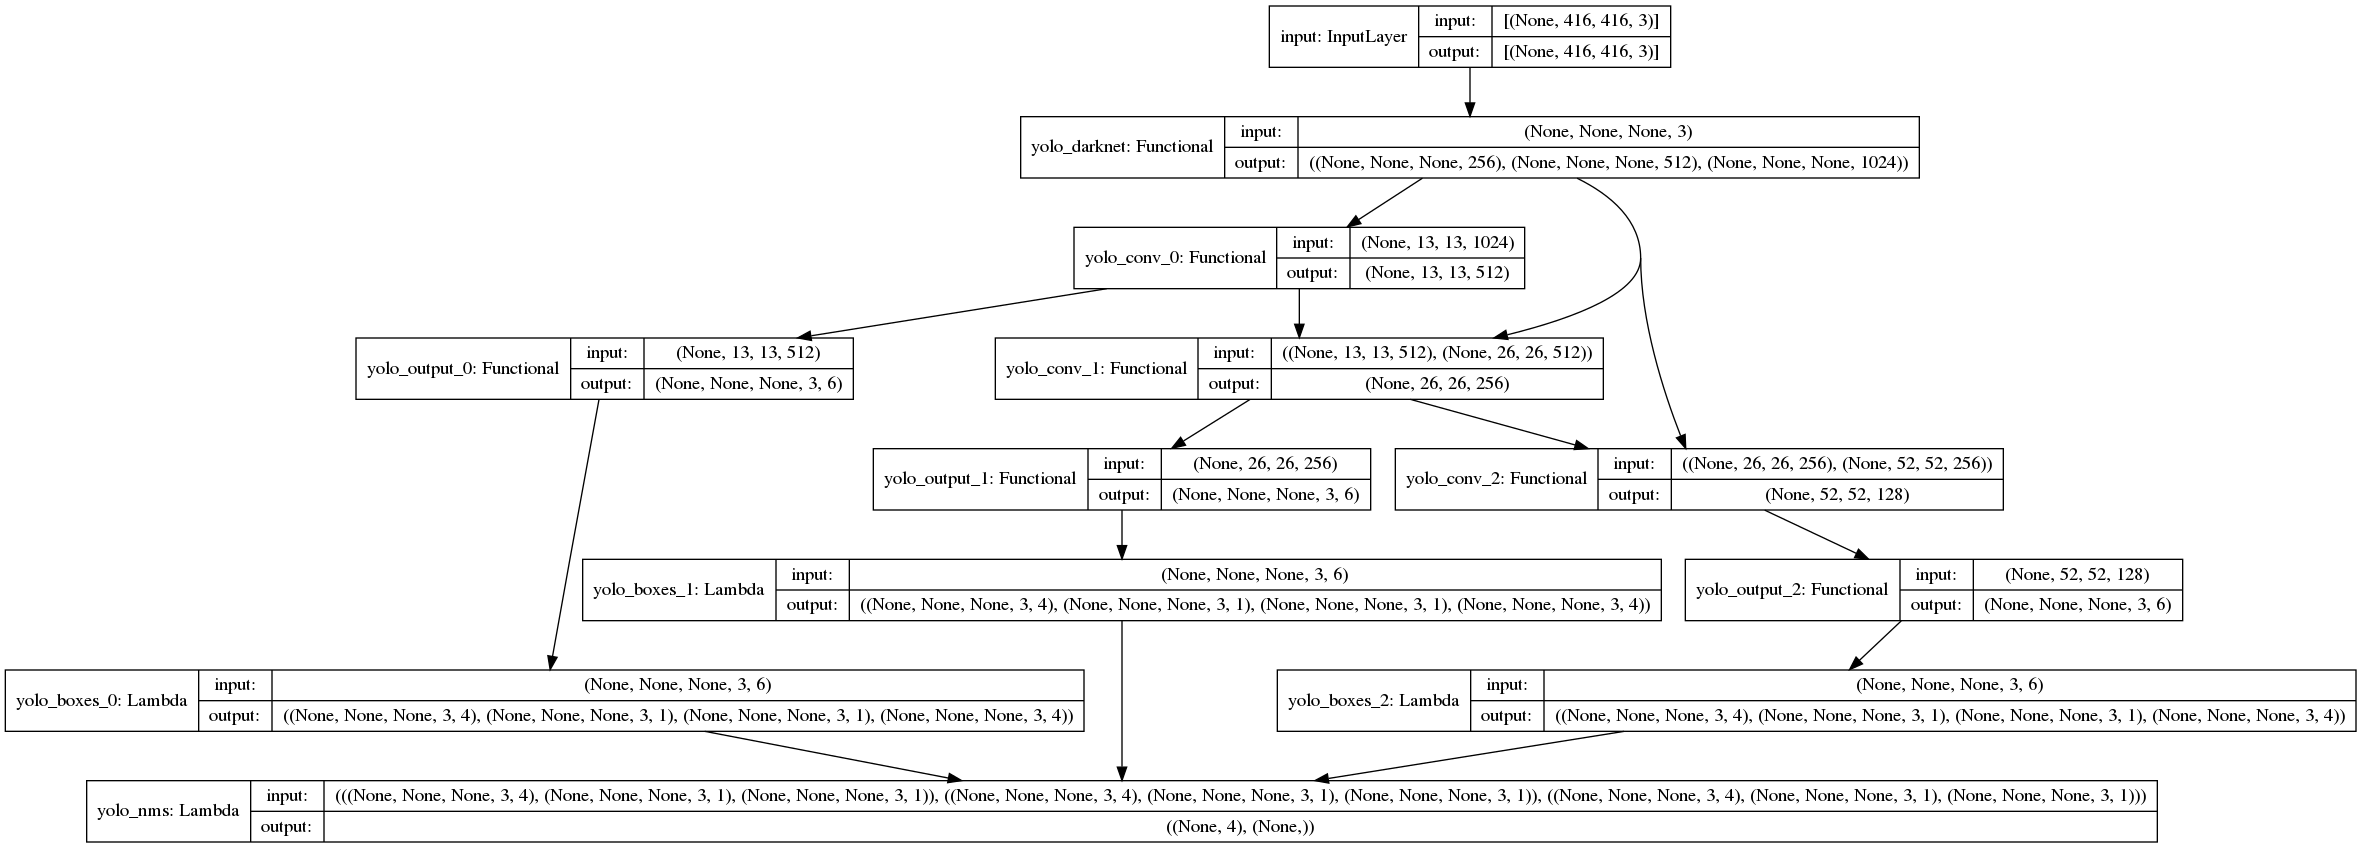

In [6]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [7]:
_model_path = 'checkpoints_01/{}-img__{}-layers__{}-bs__{}-epoch__{}-lr.tf'.format('all', 6, 64, 25, '1e-5')
print(_model_path)
model.load_weights(_model_path)

checkpoints_01/all-img__6-layers__64-bs__25-epoch__1e-5-lr.tf


# Task 1: Disaster Detection
# Load the Dataset for Disaster Detection
Define a tf.data pipeline to load the dataset
- Get images and labels from Task (a) subset - Disaster Type
- Define the functions for (i) loading images and (ii) image augmentation
- The two functions will be used by tf.data pipeline to load and augment the images
- Create tf.data.dataset instance for **Training/Validation/Testing**

In [8]:
data_root = os.path.join(FLAGS.root, 'crisis_vision_benchmarks/')

annot_train_path = os.path.join(data_root, 'tasks/disaster_types/consolidated/consolidated_disaster_types_train_final.tsv')
annot_dev_path = os.path.join(data_root, 'tasks/disaster_types/consolidated/consolidated_disaster_types_dev_final.tsv')
annot_test_path = os.path.join(data_root, 'tasks/disaster_types/consolidated/consolidated_disaster_types_test_final.tsv')
    
# training data
print('TRAINING')
df = pd.read_csv(annot_train_path, sep='\t')
train_img_paths = df['image_path'].tolist()
train_labels = df['class_label'].tolist()

def get_unique(alist):
    np_arr = np.array(alist)
    return np.unique(np_arr)

data_root = tf.convert_to_tensor(data_root, tf.string)
unique_label = get_unique(train_labels)

TRAINING


# Task 2: Load Dataset for Victim Detection
## Load the Dataset for Person Detection
- Get the pretrained model and detect for people
- Save the bbox annotation into json file
- Define a tf.data pipeline to load the dataset

In [9]:
def get_annotation(json_path, max_limit):
    with open(json_path) as f:
        # load the dataset
        json_dataset = json.load(f)
        # get data
        img_paths = []
        annots = []
        count = 0
        if max_limit is None:
            max_limit = len(json_dataset['data'])
        for data in json_dataset['data']:
            # image path
            img_paths.append(data['img_path'])
            # get the box corner (x1, y1, x2, y2)
            bboxs = data['bboxs']
            annot = []
            for bbox in bboxs:
                x1 = bbox['x1']
                y1 = bbox['y1']
                x2 = bbox['x2']
                y2 = bbox['y2']
                # last 0 is class for person
                annot += [[float(x1), float(y1), float(x2), float(y2), 0.0]]
            annot += [[0, 0, 0, 0, 0]] * (FLAGS.yolo_max_boxes - len(annot))
            annot = tf.convert_to_tensor(annot)
            annots.append(annot)
            count += 1
            if count == max_limit:
                break
                
    return img_paths, annots

MAX_LIMIT = None
train_json_path = 'others/train_damage_severity_person.json'
val_json_path = 'others/val_damage_severity_person.json'
test_json_path = 'others/test_damage_severity_person.json'

train_img_paths, train_annots = get_annotation(train_json_path, MAX_LIMIT)
val_img_paths, val_annots = get_annotation(val_json_path, MAX_LIMIT)
test_img_paths, test_annots = get_annotation(test_json_path, MAX_LIMIT)

print(len(train_annots))
print(len(val_annots))
print(len(test_annots))

5994
634
1448


# Demo 2: Person Detection

In [10]:
if FLAGS.num_classes == 80: 
    labels = [
        'person','bicycle','car','motorbike','aeroplane',
        'bus','train','truck','boat','traffic light',
        'fire hydrant','stop sign','parking meter','bench','bird',
        'cat','dog','horse','sheep','cow',
        'elephant','bear','zebra','giraffe','backpack',
        'umbrella','handbag','tie','suitcase','frisbee',
        'skis','snowboard','sports ball','kite','baseball bat',
        'baseball glove','skateboard','surfboard','tennis racket','bottle',
        'wine glass','cup','fork','knife','spoon','bowl',
        'banana','apple','sandwich','orange','broccoli',
        'carrot','hot dog','pizza','donut','cake',
        'chair','sofa','pottedplant','bed','diningtable',
        'toilet','tvmonitor','laptop','mouse','remote',
        'keyboard','cell phone','microwave','oven','toaster',
        'sink','refrigerator','book','clock','vase',
        'scissors','teddy bear','hair drier','toothbrush'
    ]
else:
    labels = ['person']
    
unique_label = ['earthquake', 'fire', 'flood', 'hurricane', 'landslide',
       'not_disaster', 'other_disaster']

In [ ]:
def nms(boxes, confidence_score, overlapThresh):
    def iou(box_1, box_2):
        width_of_overlap_area = min(box_1[1], box_2[1]) - max(box_1[0], box_2[0])
        height_of_overlap_area = min(box_1[3], box_2[3]) - max(box_1[2], box_2[2])
        if width_of_overlap_area < 0 or height_of_overlap_area < 0:
            area_of_overlap = 0
        else:
            area_of_overlap = width_of_overlap_area * height_of_overlap_area
        box_1_area = (box_1[3] - box_1[2]) * (box_1[1] - box_1[0])
        box_2_area = (box_2[3] - box_2[2]) * (box_2[1] - box_2[0])
        area_of_union = box_1_area + box_2_area - area_of_overlap
        if area_of_union == 0:
            return 0
        return area_of_overlap / area_of_union
    
    mask = confidence_score >= 0.4
    boxes, confidence_score = boxes[mask], confidence_score[mask]
    boxes, confidence_score = np.array(boxes), np.array(confidence_score)
    
    sort_idx = np.argsort(-confidence_score)
    boxes, confidence_score = boxes[sort_idx], confidence_score[sort_idx]

    for i in range(len(boxes)):
        for j in range(i + 1, len(boxes)):
            if False:
                ovr = iou(boxes[i], boxes[j])
                weight = np.exp(-(ovr * ovr) / overlapThresh)
                confidence_score[j] = confidence_score[j] * weight
            elif iou(boxes[i], boxes[j]) > overlapThresh:
                confidence_score[j] = 0
            

    mask = confidence_score >= 0.4
    boxes, confidence_score = boxes[mask], confidence_score[mask]
    valid_detections = np.shape(boxes)[0]
    classes = [0] * valid_detections

    return boxes, confidence_score, classes, valid_detections


def draw_outputs(img, outputs, class_names, label_only=True):
    boxes, objectness, classes, nums = outputs

    wh = np.flip(img.shape[0:2])
    for i in range(nums):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        if label_only:
            img = cv2.putText(img, '{}'.format(
                class_names[int(classes[i])]),
                x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
        else:
            img = cv2.putText(img, '{} {:.4f}'.format(
                class_names[int(classes[i])], objectness[i]),
                x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
    return img

In [ ]:
def show_results(path):
    img_raw = tf.image.decode_image(
        open(path, 'rb').read(), channels=3)
    img = tf.image.resize(img_raw, (FLAGS.size, FLAGS.size)) / 255
    img = tf.expand_dims(img, 0)
    print(img.shape)

    t1 = time.time()
    bbox, scores = model(img)
    boxes, scores, classes, nums = nms(bbox, scores, 0.5)

    t2 = time.time()

    img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print(img.shape)
    img = draw_outputs(img, (boxes, scores, classes, nums), labels, label_only=True)
    print(nums)

    plt.imshow(img)
    plt.show()

In [ ]:
# TRAINING
#for path in paths:
for i in [0, 1, 3, 5, 6, 7, 8, 9, 11, 12, 17, 21, 42, 300, 400, 401, 403, 406, 410, 420, 1100, 1203, 1204]:
    path = (data_root + train_img_paths[i]).numpy()
    print(f'img {i}')
    show_results(path) 

In [ ]:
# TRAINING
#for path in paths:
for i in [1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1039, 1310, 1312, 1314, 1316, 3000, 3001]:
    path = (data_root + train_img_paths[i]).numpy()
    print(f'img {i}')
    show_results(path) 

In [ ]:
# TRAINING
#for path in paths:
for i in [5, 6, 7, 8, 11, 13, 14, 15, 20, 21, 25, 26, 31, 45, 47, 49, 53, 55, 70, 96, 99, 100, 103, 105, 113, 115, 121, 122]:
    path = (data_root + val_img_paths[i]).numpy()
    print(f'img {i}')
    show_results(path) 

In [ ]:
# TRAINING
#for path in paths:
for i in [5, 6, 7, 8, 10, 11, 13, 14, 15, 20, 21, 22, 25, 26, 31, 32, 45, 47, 49, 52, 53, 55, 65, 66, 68, 70, 87, 90, 96, 99, 100]:
    path = (data_root + test_img_paths[i]).numpy()
    print(f'img {i}')
    show_results(path) 

In [ ]:
# load the actual model and anchor to be trained
model = YoloV3(FLAGS.size, 
               channels=3, 
               classes=FLAGS.num_classes, 
               auxiliary=False, 
               training=True)
anchors, anchor_masks = get_anchors(FLAGS.size)

_model_path = 'checkpoints_01/{}-img__{}-layers__{}-bs__{}-epoch__{}-lr.tf'.format('all', 6, 64, 25, '1e-5')
model.load_weights(_model_path)

# Multi-Task

In [11]:
# load the actual model and anchor to be trained
model = YoloV3(FLAGS.size, 
               channels=3, 
               classes=FLAGS.num_classes, 
               auxiliary=False, 
               training=True)
anchors, anchor_masks = get_anchors(FLAGS.size)

_model_path = 'checkpoints_01/{}-img__{}-layers__{}-bs__{}-epoch__{}-lr.tf'.format('all', 6, 64, 25, '1e-5')
model.load_weights(_model_path)

In [12]:
mtl_model = YoloV3(FLAGS.size,
                    channels=3,
                    classes=1, disaster_classes = 7,
                    yolo_iou_threshold=0.5, yolo_score_threshold=0.4,
                    auxiliary=True,
                    training=False
                  )

In [13]:
YOLOV3_LAYER_NAMES = [
    'yolo_darknet', 
    'yolo_conv_0', 'yolo_conv_1', 'yolo_conv_2',
    'yolo_output_0', 'yolo_output_1', 'yolo_output_2'
]

for layer_name in YOLOV3_LAYER_NAMES:
    mtl_model.get_layer(layer_name).set_weights(
        model.get_layer(layer_name).get_weights())

In [14]:
mtl_model.get_layer('disaster_head').load_weights('best_disaster_head.h5')

In [15]:
mtl_model.outputs

[<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'yolo_nms')>,
 <KerasTensor: shape=(None,) dtype=float32 (created by layer 'yolo_nms')>,
 <KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'disaster_head')>]

In [ ]:
path = (data_root + test_img_paths[9]).numpy()
img_raw = tf.image.decode_image(
    open(path, 'rb').read(), channels=3)
img = tf.expand_dims(img_raw, 0)
img = dataset.transform_images(img, FLAGS.size)
print(f'Resized image shape for prediction: {img.shape}\n')

t1 = time.time()
boxes, scores, classes, nums, disaster = mtl_model.predict(img)

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(f'Actual image shape: {img.shape}\n')
img = draw_outputs(img_raw.numpy(), (boxes, scores, classes, nums), labels)
print(f'Total detections:{nums}\n')
print(f'Disaster type: {unique_label[tf.argmax(disaster[0]).numpy()]}\n')

plt.imshow(img)
plt.show()

# cv2.imshow('output', img)
# cv2.waitKey(1)

# cv2.imwrite('savedImage.jpg', cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
t2 = time.time()
print(t2-t1)

In [ ]:
mtl_model.load_weights('mtl_model.h5')

In [16]:
mtl_model.save_weights('mtl_model_rpi.h5')

In [17]:
mtl_model.load_weights('mtl_model_rpi.h5')

In [18]:
mtl_model.save("mtl_model_rpi")

2022-06-06 02:07:47.222731: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/home/tham/anaconda3/envs/rns/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: mtl_model_rpi/assets
